In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/train

Mounted at /gdrive
/gdrive/My Drive/train


In [2]:
from scipy.io import loadmat
import numpy as np, os, sys, joblib
import matplotlib.pyplot as plt
import scipy.signal as signal
import math
from tqdm import tqdm
import pandas as pd
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
import sklearn
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import itertools


SEED = 1234
np.random.seed(SEED)
pd.core.common._random_stat = SEED
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [3]:
from sklearn.model_selection import train_test_split
import os
import re

In [4]:
path_to_data = "/gdrive/My Drive/train"

In [5]:
# Utility: given the filename of a signal it returns the sampling frequency
def ppg_freq(filename):
  if '128' in filename:
    return 128
  else:
    return 250

In [6]:
def load_data(file):

  original = loadmat(file) #  dictionary with variable names as keys, and loaded matrices as values

  spk_file = file.replace('.mat', '_spk.mat')
  spk = loadmat(spk_file)

  ann_file = file.replace('.mat', '_ann.mat')
  ann = loadmat(ann_file)

  return original, spk, ann

In [7]:
def filter_files_by_pattern(directory, pattern):
    """
    Filter files in a directory based on a specified pattern.

    Parameters:
    - directory: The directory containing the files.
    - pattern: The regular expression pattern to match filenames.

    Returns:
    - List of filenames matching the pattern.
    """
    files = os.listdir(directory)
    filtered_files = [file for file in files if re.match(pattern, file)]
    return filtered_files

In [8]:
directory = path_to_data
pattern = r'S\d{3}_\d{3}\.mat'  # Regular expression pattern matching 'SXXX_YYY.mat'

filtered_files = filter_files_by_pattern(directory, pattern)
print(filtered_files)

['S001_128.mat', 'S002_128.mat', 'S003_128.mat', 'S004_128.mat', 'S005_128.mat', 'S006_128.mat', 'S007_128.mat', 'S008_128.mat', 'S009_128.mat', 'S010_128.mat', 'S011_128.mat', 'S012_128.mat', 'S013_128.mat', 'S014_128.mat', 'S015_128.mat', 'S016_128.mat', 'S017_128.mat', 'S018_128.mat', 'S019_128.mat', 'S020_128.mat', 'S021_128.mat', 'S022_128.mat', 'S023_128.mat', 'S024_128.mat', 'S025_128.mat', 'S026_128.mat', 'S027_128.mat', 'S028_128.mat', 'S029_128.mat', 'S030_128.mat', 'S031_128.mat', 'S032_128.mat', 'S033_128.mat', 'S034_128.mat', 'S035_128.mat', 'S036_128.mat', 'S037_128.mat', 'S038_128.mat', 'S039_128.mat', 'S040_128.mat', 'S041_128.mat', 'S042_128.mat', 'S043_128.mat', 'S044_128.mat', 'S045_128.mat', 'S046_128.mat', 'S047_128.mat', 'S048_128.mat', 'S049_128.mat', 'S050_128.mat', 'S051_128.mat', 'S052_128.mat', 'S053_128.mat', 'S054_128.mat', 'S055_128.mat', 'S056_128.mat', 'S057_128.mat', 'S058_128.mat', 'S059_128.mat', 'S060_128.mat', 'S061_128.mat', 'S062_128.mat', 'S079_2

In [9]:
type(filtered_files)
len(filtered_files)

105

In [10]:
data = []
ppg_data = []
spk_data = []
ann_data = []

for file in filtered_files:
  ppg, spk, ann = load_data(path_to_data + '/' + file)
  ppg_data.append(ppg)
  spk_data.append(spk)
  ann_data.append(ann)

  data.append(path_to_data + '/' + file)

In [11]:
ppg_data

[{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACA64, Created on: Tue Nov  7 09:57:28 2023',
  '__version__': '1.0',
  '__globals__': [],
  'ppg': array([[-2.38138363],
         [-2.38135063],
         [-2.38131159],
         ...,
         [-3.93333424],
         [-4.06168546],
         [-4.2308891 ]])},
 {'__header__': b'MATLAB 5.0 MAT-file, Platform: MACA64, Created on: Tue Nov  7 09:57:28 2023',
  '__version__': '1.0',
  '__globals__': [],
  'ppg': array([[-1.62433622],
         [-1.62433622],
         [-1.62433622],
         ...,
         [-1.7324762 ],
         [-1.27083778],
         [-1.31682689]])},
 {'__header__': b'MATLAB 5.0 MAT-file, Platform: MACA64, Created on: Tue Nov  7 09:57:28 2023',
  '__version__': '1.0',
  '__globals__': [],
  'ppg': array([[-2.42002693],
         [-2.4200018 ],
         [-2.41997314],
         ...,
         [-2.41322432],
         [-2.41333122],
         [-2.41343626]])},
 {'__header__': b'MATLAB 5.0 MAT-file, Platform: MACA64, Created on: Tue 

##Droping files with all normal beats

In [12]:
# Function to check if all annotations are 'N'
def all_annotations_N(annotations):
    labels = annotations.get('labels', [])
    return all(label == 'N' for label in labels)

# Collect file names with all 'N' annotations
files_with_all_N = [os.path.basename(data[i]) for i, ann in enumerate(ann_data) if all_annotations_N(ann)]

# Print file names with all 'N' annotations
print("Files with all 'N' annotations:", files_with_all_N)

Files with all 'N' annotations: ['S085_250.mat', 'S092_250.mat', 'S095_250.mat', 'S096_250.mat', 'S104_250.mat', 'S105_250.mat', 'S107_250.mat', 'S108_250.mat', 'S110_250.mat', 'S111_250.mat', 'S115_250.mat', 'S119_250.mat', 'S120_250.mat', 'S121_250.mat']


In [13]:
files_with_all_N

['S085_250.mat',
 'S092_250.mat',
 'S095_250.mat',
 'S096_250.mat',
 'S104_250.mat',
 'S105_250.mat',
 'S107_250.mat',
 'S108_250.mat',
 'S110_250.mat',
 'S111_250.mat',
 'S115_250.mat',
 'S119_250.mat',
 'S120_250.mat',
 'S121_250.mat']

In [14]:
count_files_with_all_N = len(files_with_all_N)
count_files_with_all_N


14

In [15]:
import scipy.io
# Load the .mat file
mat_file_path = '/gdrive/My Drive/train/S121_250_ann.mat'
mat_contents = scipy.io.loadmat(mat_file_path)

# Extract the 'labels' data
labels_data = mat_contents['labels']

# Display the contents of 'labels'
print(labels_data[2200:2500])  # View the first 100 entries


['N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N'
 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N'
 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N'
 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N'
 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N'
 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N'
 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N'
 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N'
 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N'
 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N'
 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N'
 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N'
 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N'
 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N

In [16]:
filtered_files_updated = [file for file in filtered_files if os.path.basename(file) not in files_with_all_N]

# Print the updated list of filtered files
print("Updated filtered files:", filtered_files_updated)

Updated filtered files: ['S001_128.mat', 'S002_128.mat', 'S003_128.mat', 'S004_128.mat', 'S005_128.mat', 'S006_128.mat', 'S007_128.mat', 'S008_128.mat', 'S009_128.mat', 'S010_128.mat', 'S011_128.mat', 'S012_128.mat', 'S013_128.mat', 'S014_128.mat', 'S015_128.mat', 'S016_128.mat', 'S017_128.mat', 'S018_128.mat', 'S019_128.mat', 'S020_128.mat', 'S021_128.mat', 'S022_128.mat', 'S023_128.mat', 'S024_128.mat', 'S025_128.mat', 'S026_128.mat', 'S027_128.mat', 'S028_128.mat', 'S029_128.mat', 'S030_128.mat', 'S031_128.mat', 'S032_128.mat', 'S033_128.mat', 'S034_128.mat', 'S035_128.mat', 'S036_128.mat', 'S037_128.mat', 'S038_128.mat', 'S039_128.mat', 'S040_128.mat', 'S041_128.mat', 'S042_128.mat', 'S043_128.mat', 'S044_128.mat', 'S045_128.mat', 'S046_128.mat', 'S047_128.mat', 'S048_128.mat', 'S049_128.mat', 'S050_128.mat', 'S051_128.mat', 'S052_128.mat', 'S053_128.mat', 'S054_128.mat', 'S055_128.mat', 'S056_128.mat', 'S057_128.mat', 'S058_128.mat', 'S059_128.mat', 'S060_128.mat', 'S061_128.mat',

In [17]:
len(filtered_files_updated)

91

##Unifying the sampling frequency

In [18]:
# Initialize counters
count_128 = 0
count_250 = 0

# Iterate over the list of filenames and count frequencies
for filename in filtered_files_updated:
    freq = ppg_freq(filename)
    if freq == 128:
        count_128 += 1
    elif freq == 250:
        count_250 += 1

# Print the results
print(f"Number of files with 128 Hz sampling frequency: {count_128}")
print(f"Number of files with 250 Hz sampling frequency: {count_250}")

Number of files with 128 Hz sampling frequency: 62
Number of files with 250 Hz sampling frequency: 29


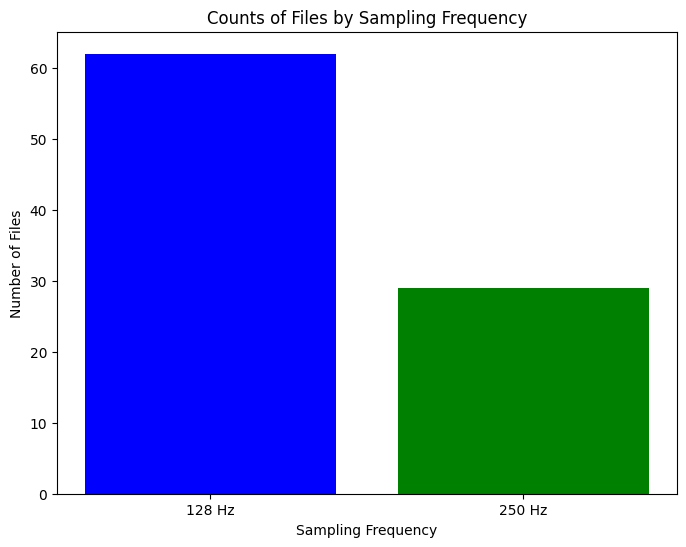

In [19]:
# Plot the counts
frequencies = ['128 Hz', '250 Hz']
counts = [count_128, count_250]

plt.figure(figsize=(8, 6))
plt.bar(frequencies, counts, color=['blue', 'green'])
plt.xlabel('Sampling Frequency')
plt.ylabel('Number of Files')
plt.title('Counts of Files by Sampling Frequency')
plt.show()

##Splitting the data into two groups

In [20]:
# List to store the percentage of 'N' annotations for each file
n_annotations_percentage = []

# Process each file in filtered_files_updated
for file in filtered_files_updated:
    _, _, ann = load_data(path_to_data + '/' + file)
    labels = ann.get('labels', [])
    if len(labels) > 0:
        n_count = np.sum(labels == 'N')
        total_count = len(labels)
        percentage_n = (n_count / total_count) * 100
        n_annotations_percentage.append(percentage_n)

# Compute statistics
max_n_percentage = np.max(n_annotations_percentage)
min_n_percentage = np.min(n_annotations_percentage)
median_n_percentage = np.median(n_annotations_percentage)
average_n_percentage = np.mean(n_annotations_percentage)
total_n_percentage = np.sum(n_annotations_percentage)

# Print statistics
print(f"Maximum percentage of 'N' annotations: {max_n_percentage:.2f}%")
print(f"Minimum percentage of 'N' annotations: {min_n_percentage:.2f}%")
print(f"Median percentage of 'N' annotations: {median_n_percentage:.2f}%")
print(f"Average percentage of 'N' annotations: {average_n_percentage:.2f}%")
print(f"Total percentage of 'N' annotations: {total_n_percentage:.2f}%")

Maximum percentage of 'N' annotations: 99.97%
Minimum percentage of 'N' annotations: 35.04%
Median percentage of 'N' annotations: 96.54%
Average percentage of 'N' annotations: 92.40%
Total percentage of 'N' annotations: 8408.34%


In [21]:
# Determine the threshold, for example using the median
threshold = np.median(n_annotations_percentage)

# Group patients based on the threshold
dominantly_n_files = [file for i, file in enumerate(filtered_files_updated) if n_annotations_percentage[i] >= threshold]
few_n_files = [file for i, file in enumerate(filtered_files_updated) if n_annotations_percentage[i] < threshold]

# Print the threshold and grouped files
print(f"Threshold for percentage of 'N' annotations: {threshold:.2f}%")
print(f"Files with dominantly 'N' annotations: {dominantly_n_files}")
print(f"Files with fewer 'N' annotations: {few_n_files}")

Threshold for percentage of 'N' annotations: 96.54%
Files with dominantly 'N' annotations: ['S003_128.mat', 'S006_128.mat', 'S013_128.mat', 'S015_128.mat', 'S017_128.mat', 'S022_128.mat', 'S023_128.mat', 'S024_128.mat', 'S028_128.mat', 'S033_128.mat', 'S035_128.mat', 'S037_128.mat', 'S038_128.mat', 'S042_128.mat', 'S046_128.mat', 'S050_128.mat', 'S055_128.mat', 'S056_128.mat', 'S059_128.mat', 'S060_128.mat', 'S061_128.mat', 'S079_250.mat', 'S080_250.mat', 'S081_250.mat', 'S082_250.mat', 'S083_250.mat', 'S084_250.mat', 'S087_250.mat', 'S088_250.mat', 'S089_250.mat', 'S090_250.mat', 'S091_250.mat', 'S093_250.mat', 'S094_250.mat', 'S097_250.mat', 'S098_250.mat', 'S099_250.mat', 'S100_250.mat', 'S101_250.mat', 'S103_250.mat', 'S109_250.mat', 'S112_250.mat', 'S113_250.mat', 'S114_250.mat', 'S116_250.mat', 'S118_250.mat']
Files with fewer 'N' annotations: ['S001_128.mat', 'S002_128.mat', 'S004_128.mat', 'S005_128.mat', 'S007_128.mat', 'S008_128.mat', 'S009_128.mat', 'S010_128.mat', 'S011_128

In [22]:
len(dominantly_n_files), len(few_n_files)

(46, 45)

##Splitting the data into training,Testing,Validation Sets

In [23]:
# Function to split data into train, test, and validation sets
def split_data(files, train_size=0.7, test_size=0.2, val_size=0.1):
    train_files, test_val_files = train_test_split(files, train_size=train_size, random_state=42)
    test_files, val_files = train_test_split(test_val_files, test_size=val_size/(test_size + val_size), random_state=42)
    return train_files, test_files, val_files

# Split each group
dominantly_n_train, dominantly_n_test, dominantly_n_val = split_data(dominantly_n_files)
few_n_train, few_n_test, few_n_val = split_data(few_n_files)

# Combine the groups
train_files = dominantly_n_train + few_n_train
test_files = dominantly_n_test + few_n_test
val_files = dominantly_n_val + few_n_val

# Print the number of files in each set
print(f"Number of training files: {len(train_files)}")
print(f"Number of testing files: {len(test_files)}")
print(f"Number of validation files: {len(val_files)}")


Number of training files: 63
Number of testing files: 18
Number of validation files: 10


In [24]:
train = []
ppg_train = []
spk_train = []
ann_train = []


for file in train_files:
  ppg, spk, ann = load_data(path_to_data + '/' + file)
  ppg_train.append(ppg)
  spk_train.append(spk)
  ann_train.append(ann)

  train.append(path_to_data + '/' + file)

In [25]:
testing = []
ppg_testing = []
spk_testing = []
ann_testing = []

for file in test_files:

  ppg, spk, ann = load_data(path_to_data + '/' + file)
  ppg_testing.append(ppg)
  spk_testing.append(spk)
  ann_testing.append(ann)

  testing.append(path_to_data + '/' + file)

In [26]:
validation = []
ppg_validation = []
spk_validation = []
ann_validation = []

for file in val_files:

  ppg, spk, ann = load_data(path_to_data + '/' + file)
  ppg_validation.append(ppg)
  spk_validation.append(spk)
  ann_validation.append(ann)

  validation.append(path_to_data + '/' + file)

**Ratio between labels **

Counts of each label: {'N': 136867, 'S': 5345, 'V': 5658}


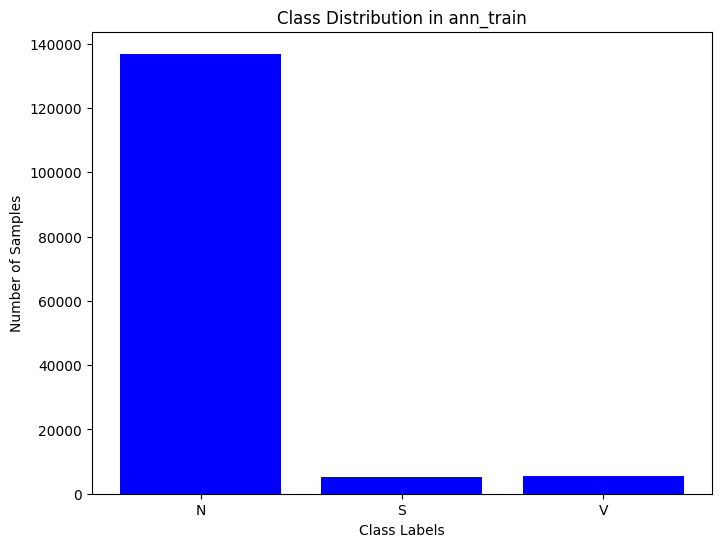

In [27]:
from collections import Counter
import numpy as np

# Initialize an empty Counter to hold label counts
label_counter = Counter()

# Iterate through each dictionary in ann_train
for ann in ann_train:
    labels = ann['labels']
    # Update the counter with labels from the current dictionary
    label_counter.update(labels)

# Print the total counts for each label
print("Counts of each label:", dict(label_counter))

# Optionally, convert the Counter to a dictionary and plot the counts
labels, counts = zip(*label_counter.items())

# Plotting the counts
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.bar(labels, counts, color='blue')
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in ann_train')
plt.show()

In [28]:
! pip install neurokit2 tdqm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.2/689.2 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for tdqm: filename=tdqm-0.0.1-py3-none-any.whl size=1323 sha256=b1a9241403cdbfa490e130d92985b78b99ccc1ce143614813624fab3ea9091b1
  Stored in directory: /root/.cache/pip/wheels/37/31/b8/7b711038035720ba0df14376af06e5e76b9bd61759c861ad92
Successfully built tdqm


In [29]:
import scipy

In [30]:
def normalize(data):
    return (data - np.mean(data)) / np.std(data)


In [31]:
# Resample and normalize to 250 Hz training PPG signals
normalized_ppg_1_train = []
for i in range(len(ppg_train)):
    original_fs = ppg_freq(train[i])
    if original_fs != 250:
        resampled = signal.resample_poly(ppg_train[i]['ppg'][:, 0], 250, original_fs)
    else:
        resampled = ppg_train[i]['ppg'][:, 0]
    normalized = normalize(resampled)
    normalized_ppg_1_train.append(normalized)

# Resample and normalize to 250 Hz validation PPG signals
normalized_ppg_1_validation = []
for i in range(len(ppg_validation)):
    original_fs = ppg_freq(validation[i])
    if original_fs != 250:
        resampled = signal.resample_poly(ppg_validation[i]['ppg'][:, 0], 250, original_fs)
    else:
        resampled = ppg_validation[i]['ppg'][:, 0]
    normalized = normalize(resampled)
    normalized_ppg_1_validation.append(normalized)


# Resample and normalize to 250 Hz training PPG signals
normalized_ppg_1_testing = []
for i in range(len(ppg_testing)):
    original_fs = ppg_freq(testing[i])
    if original_fs != 250:
        resampled = signal.resample_poly(ppg_testing[i]['ppg'][:, 0], 250, original_fs)
    else:
        resampled = ppg_testing[i]['ppg'][:, 0]
    normalized = normalize(resampled)
    normalized_ppg_1_testing.append(normalized)

# Define the Butterworth bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

# Apply the Butterworth filter to the signal
def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order)
    y = signal.lfilter(b, a, data)
    return y

# Filter parameters
lowcut = 0.5
highcut = 6.0
fs = 250

# Apply the Butterworth filter to normalized training data
filtered_ppg_1_train = []
for i in range(len(normalized_ppg_1_train)):
    filtered_ppg_1_train.append(butter_bandpass_filter(normalized_ppg_1_train[i], lowcut, highcut, fs))

# Apply the Butterworth filter to normalized validation data
filtered_ppg_1_validation = []
for i in range(len(normalized_ppg_1_validation)):
    filtered_ppg_1_validation.append(butter_bandpass_filter(normalized_ppg_1_validation[i], lowcut, highcut, fs))

# Apply the Butterworth filter to normalized testing data
filtered_ppg_1_testing = []
for i in range(len(normalized_ppg_1_testing)):
    filtered_ppg_1_testing.append(butter_bandpass_filter(normalized_ppg_1_testing[i], lowcut, highcut, fs))

# Function to plot PPG signals
def plot_ppg_signals(subject_index, xlim=(0, 1000), ylim=(-5, 5)):
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    plt.plot(normalized_ppg_1_train[subject_index], label='Normalized 250Hz')
    plt.title(f'Subject {subject_index + 1}: {train_files[subject_index]} - Resampled PPG')
    plt.title(f'Subject {subject_index + 1}: Normalized PPG')
    plt.legend()
    plt.xlim(xlim)
    plt.ylim(ylim)

    plt.subplot(2, 1, 2)
    plt.plot(filtered_ppg_1_train[subject_index], label='Filtered 0.5-10Hz')
    plt.title(f'Subject {subject_index + 1}: Filtered PPG')
    plt.legend()
    plt.xlim(xlim)
    plt.ylim(ylim)

    plt.tight_layout()
    plt.show()
resampled_ppg_1_train = filtered_ppg_1_train
resampled_ppg_1_validation = filtered_ppg_1_validation
resampled_ppg_1_testing = filtered_ppg_1_testing

In [32]:
len(resampled_ppg_1_train)

63

In [33]:
len(resampled_ppg_1_validation)

10

In [34]:
len(resampled_ppg_1_testing)

18

250

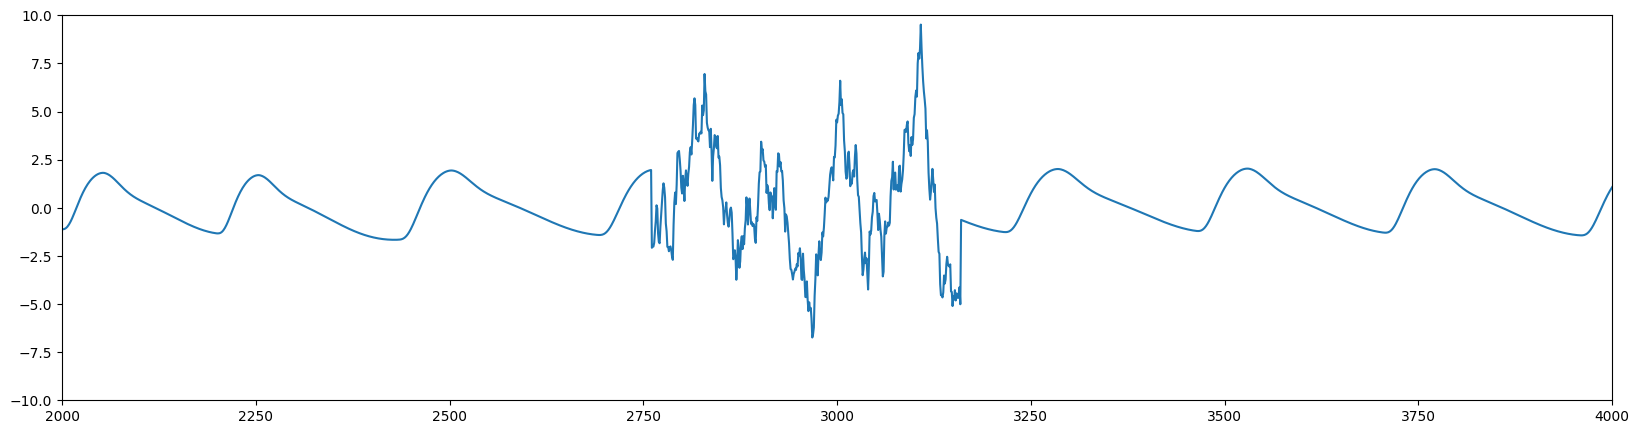

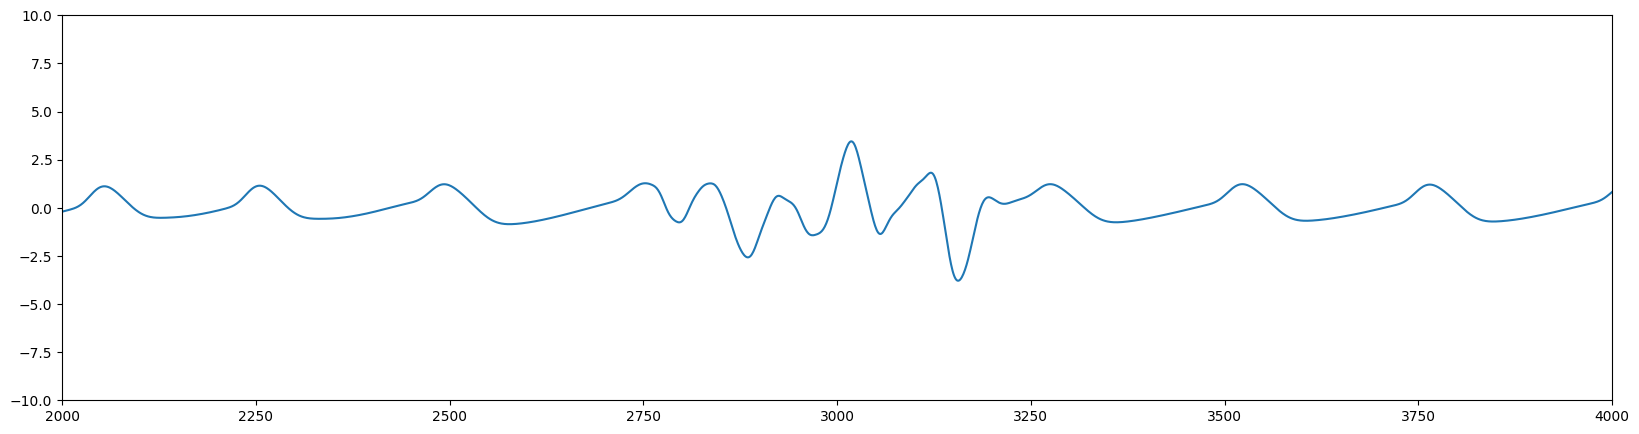

In [35]:
# plot the effect of the denoising procedure showing a piece of PPG before and after the applications of filters

x = 11
plt.figure(figsize=(20, 5))
plt.plot(ppg_train[x]['ppg'][:,0])
plt.xlim(2000, 4000)
plt.ylim(-10,10)
plt.figure(figsize=(20, 5))
plt.plot(resampled_ppg_1_train[x])
plt.xlim(2000, 4000)
plt.ylim(-10,10)
ppg_freq(train[x])


In [36]:
spk_train[0]['speaks']

array([[   110],
       [   220],
       [   332],
       ...,
       [229756],
       [229884],
       [230013]], dtype=int32)

In [37]:
spk_train[1]['speaks']

array([[    87],
       [   176],
       [   262],
       ...,
       [229860],
       [229950],
       [230042]], dtype=int32)

In [38]:
def from_freq_to_freq(sample, ini_freq, freq = 250):
   secs = sample/ini_freq # Number of seconds in signal X
   samp = secs*freq       # Number of samples to downsample
   return int(samp)

In [39]:
# This parameter is the number of samples considered to segment the PPG signal (the segment will be the samples of current R peak +/- win)
win = 250

In [40]:
# Extract all the segments (single heartbeats) from the original raw signals

heartbeats_train_1 = []
heartbeats_validation_1 = []
heartbeats_testing_1 = []

for i in range(len(ppg_train)):
  for j in range(len(spk_train[i]['speaks'])):
   if(from_freq_to_freq(spk_train[i]['speaks'][j],ppg_freq(train[i])) < win or from_freq_to_freq(spk_train[i]['speaks'][j],ppg_freq(train[i]))  + win > from_freq_to_freq(spk_train[i]['speaks'][-1],ppg_freq(train[i])) or j < 40 or (len(spk_train[i]['speaks']) - (j+1) < 40)): #skipping beats that are too much close to the initial and to the end of the signal
    ann_train[i]['labels'][j] = 'A'
    spk_train[i]['speaks'][j] = 0
   else:
    heartbeats_train_1.append(resampled_ppg_1_train[i][from_freq_to_freq(spk_train[i]['speaks'][j],ppg_freq(train[i]))  - win : from_freq_to_freq(spk_train[i]['speaks'][j],ppg_freq(train[i]))  + win])

for i in range(len(ppg_validation)):
  for j in range(len(spk_validation[i]['speaks'])):
   if(from_freq_to_freq(spk_validation[i]['speaks'][j],ppg_freq(validation[i])) < win or from_freq_to_freq(spk_validation[i]['speaks'][j],ppg_freq(validation[i])) + win > from_freq_to_freq(spk_validation[i]['speaks'][-1],ppg_freq(validation[i]))): #skipping beats that are too much close to the initial and to the end of the signal
    ann_validation[i]['labels'][j] = 'A'
    spk_validation[i]['speaks'][j] = 0
   else:
    heartbeats_validation_1.append(resampled_ppg_1_validation[i][from_freq_to_freq(spk_validation[i]['speaks'][j],ppg_freq(validation[i]))  - win : from_freq_to_freq(spk_validation[i]['speaks'][j],ppg_freq(validation[i]))  + win])

for i in range(len(ppg_testing)):
  for j in range(len(spk_testing[i]['speaks'])):
   if(from_freq_to_freq(spk_testing[i]['speaks'][j],ppg_freq(testing[i])) < win or from_freq_to_freq(spk_testing[i]['speaks'][j],ppg_freq(testing[i]))  + win > from_freq_to_freq(spk_testing[i]['speaks'][-1],ppg_freq(testing[i])) or j < 40 or (len(spk_testing[i]['speaks']) - (j+1) < 40)): #skipping beats that are too much close to the initial and to the end of the signal
    ann_testing[i]['labels'][j] = 'A'
    spk_testing[i]['speaks'][j] = 0
   else:
    heartbeats_testing_1.append(resampled_ppg_1_testing[i][from_freq_to_freq(spk_testing[i]['speaks'][j],ppg_freq(testing[i]))  - win : from_freq_to_freq(spk_testing[i]['speaks'][j],ppg_freq(testing[i]))  + win])


<ipython-input-38-ead6d838464d>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(samp)


In [41]:
len(spk_train[0]['speaks']), len(np.delete(spk_train[0]['speaks'], 0))

(1859, 1858)

In [42]:
len(heartbeats_train_1), len(heartbeats_validation_1), len(heartbeats_testing_1)

(142830, 26044, 39968)

In [43]:
len(heartbeats_train_1)

142830

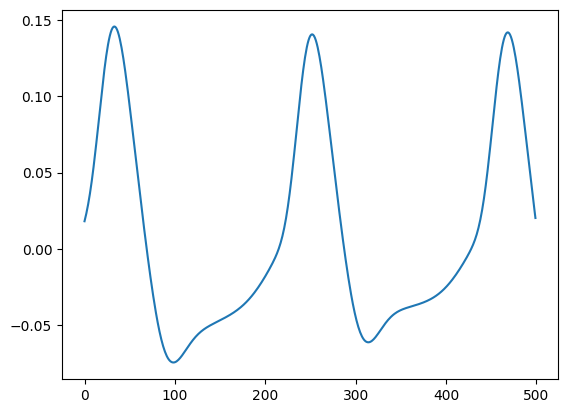

In [44]:
import matplotlib.pyplot as plt

# plot an example of segment
plt.plot(heartbeats_train_1[100])

Number of segments with peak-to-peak amplitude > 5: 13924
Number of segments with peak-to-peak amplitude <= 5: 128906


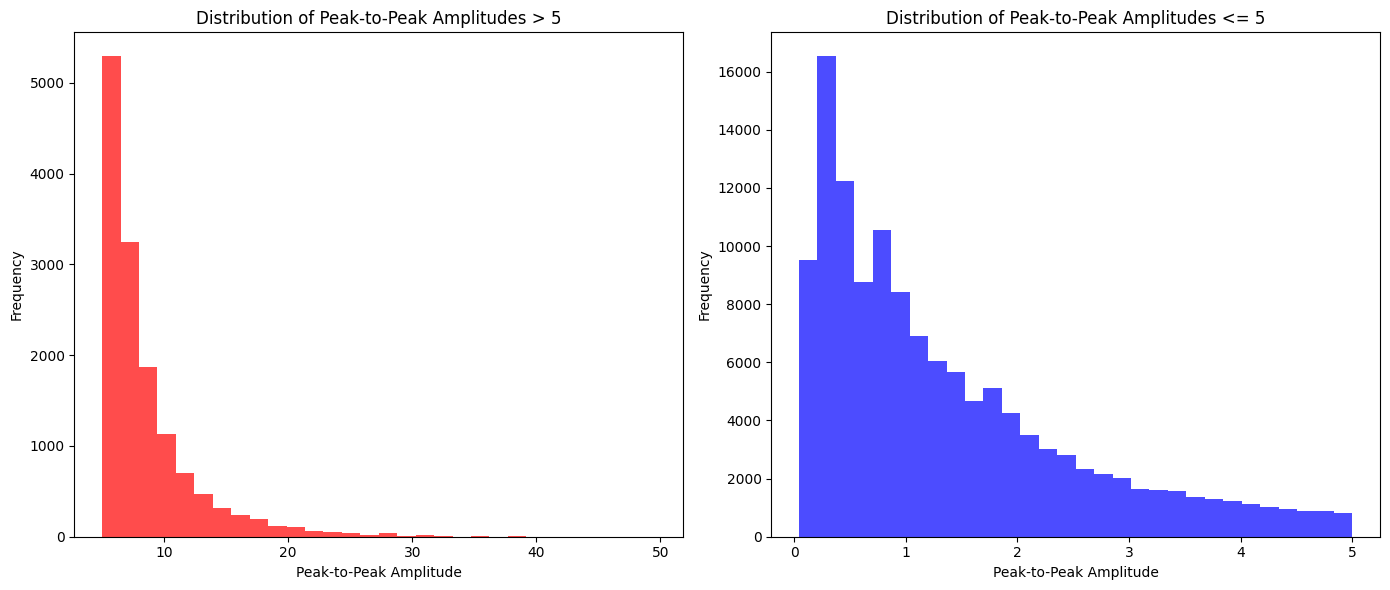

In [45]:
import matplotlib.pyplot as plt

# Initialize two lists for peak-to-peak amplitudes
high_amplitude_peaks = []
low_amplitude_peaks = []

# Iterate through the heartbeats and separate the peak-to-peak amplitudes
for i in range(len(heartbeats_train_1)):
    max_val = np.max(heartbeats_train_1[i])
    min_val = np.min(heartbeats_train_1[i])
    peak_to_peak_amplitude = max_val - min_val

    if peak_to_peak_amplitude > 5:
        high_amplitude_peaks.append(peak_to_peak_amplitude)
    else:
        low_amplitude_peaks.append(peak_to_peak_amplitude)

# Print the count of each category
print(f"Number of segments with peak-to-peak amplitude > 5: {len(high_amplitude_peaks)}")
print(f"Number of segments with peak-to-peak amplitude <= 5: {len(low_amplitude_peaks)}")

# Plot the distributions
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(high_amplitude_peaks, bins=30, color='r', alpha=0.7)
plt.title('Distribution of Peak-to-Peak Amplitudes > 5')
plt.xlabel('Peak-to-Peak Amplitude')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(low_amplitude_peaks, bins=30, color='b', alpha=0.7)
plt.title('Distribution of Peak-to-Peak Amplitudes <= 5')
plt.xlabel('Peak-to-Peak Amplitude')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [46]:
labels_train = []
labels_validation = []
labels_testing = []

for i in range(len(ppg_train)):
  for j in range(len(ann_train[i]['labels'])):
    if(ann_train[i]['labels'][j] != 'A'):
     labels_train.append(ann_train[i]['labels'][j])

for i in range(len(ppg_validation)):
  for j in range(len(ann_validation[i]['labels'])):
    if(ann_validation[i]['labels'][j] != 'A'):
     labels_validation.append(ann_validation[i]['labels'][j])


for i in range(len(ppg_testing)):
  for j in range(len(ann_testing[i]['labels'])):
    if(ann_testing[i]['labels'][j] != 'A'):
     labels_testing.append(ann_testing[i]['labels'][j])


In [47]:
# Lists to store valid heartbeats, labels, and spk values
valid_heartbeats_train = []
valid_labels_train = []
valid_ann_train = []

# Iterate through the heartbeats and keep only those with peak-to-peak amplitude <= 5
for i in range(len(heartbeats_train_1)):
    max_val = np.max(heartbeats_train_1[i])
    min_val = np.min(heartbeats_train_1[i])
    peak_to_peak_amplitude = max_val - min_val

    if peak_to_peak_amplitude <= 5:
        valid_heartbeats_train.append(heartbeats_train_1[i])
        valid_labels_train.append(labels_train[i])
        valid_ann_train.append(labels_train[i])

# Print the count of remaining segments
print(f"Number of valid training segments after removal: {len(valid_heartbeats_train)}")
print(f"Number of valid training labels after removal: {len(valid_ann_train)}")



Number of valid training segments after removal: 128906
Number of valid training labels after removal: 128906


In [48]:
labels_train = []
labels_validation = []

for i in range(len(ppg_train)):
  for j in range(len(ann_train[i]['labels'])):
    if(ann_train[i]['labels'][j] != 'A'):
     labels_train.append(ann_train[i]['labels'][j])

for i in range(len(ppg_validation)):
  for j in range(len(ann_validation[i]['labels'])):
    if(ann_validation[i]['labels'][j] != 'A'):
     labels_validation.append(ann_validation[i]['labels'][j])


In [49]:
# Lists to store valid heartbeats, labels, and spk values
valid_heartbeats_testing = []
valid_labels_testing = []
valid_ann_testing = []

# Iterate through the heartbeats and keep only those with peak-to-peak amplitude <= 5
for i in range(len(heartbeats_testing_1)):
      valid_heartbeats_testing.append(heartbeats_testing_1[i])
      valid_labels_testing.append(labels_testing[i])
      valid_ann_testing.append(labels_testing[i])

# Print the count of remaining segments
print(f"Number of valid training segments after removal: {len(valid_heartbeats_testing)}")
print(f"Number of valid training labels after removal: {len(valid_ann_testing)}")



Number of valid training segments after removal: 39968
Number of valid training labels after removal: 39968


In [50]:
classes_name = ['N', 'S', 'V']

In [51]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels_train)

#One hot encoding of the target values
ohe = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
target_ohe_train = ohe.fit_transform(integer_encoded)

integer_encoded = label_encoder.fit_transform(labels_validation)

#One hot encoding of the target values
ohe = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
target_ohe_validation = ohe.fit_transform(integer_encoded)

integer_encoded = label_encoder.fit_transform(labels_testing)

#One hot encoding of the target values
ohe = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
target_ohe_testing = ohe.fit_transform(integer_encoded)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [52]:
label_encoder.inverse_transform([0,1,2])

array(['N', 'S', 'V'], dtype='<U1')

In [53]:
ohe.inverse_transform([[1, 0, 0], [0,1,0], [0,0,1]])

array([[0],
       [1],
       [2]])

In [54]:
y_train = target_ohe_train
y_val = target_ohe_validation
y_test = target_ohe_testing

In [55]:
X_train_1 = tf.keras.preprocessing.sequence.pad_sequences(heartbeats_train_1, maxlen=win * 2, dtype='float32', truncating='post',padding="post")
#X_train_2 = tf.keras.preprocessing.sequence.pad_sequences(heartbeats_train_2, maxlen=win * 2, dtype='float32', truncating='post',padding="post")
X_test_1 = tf.keras.preprocessing.sequence.pad_sequences(heartbeats_testing_1, maxlen=win * 2, dtype='float32', truncating='post',padding="post")

X_val_1 = tf.keras.preprocessing.sequence.pad_sequences(heartbeats_validation_1, maxlen=win * 2, dtype='float32', truncating='post',padding="post")
#X_val_2 = tf.keras.preprocessing.sequence.pad_sequences(heartbeats_validation_2, maxlen=win * 2, dtype='float32', truncating='post',padding="post")


In [56]:
y_train.shape

(142830, 3)

In [57]:
y_val.shape

(26044, 3)

In [58]:
y_test.shape

(39968, 3)

In [59]:
X_train_1.shape

(142830, 500)

In [60]:
X_val_1.shape

(26044, 500)

In [61]:
X_test_1.shape

(39968, 500)

In [62]:
X_train = []
for i in range(len(X_train_1)):
  X_train.append(X_train_1[i])

X_train = np.asarray(X_train)

In [63]:
X_test= []
for i in range(len(X_test_1)):
  X_test.append(X_test_1[i])

X_test = np.asarray(X_test)

In [64]:
X_val = []
for i in range(len(X_val_1)):
  X_val.append(X_val_1[i])

X_val = np.asarray(X_val)

(142830, 500)

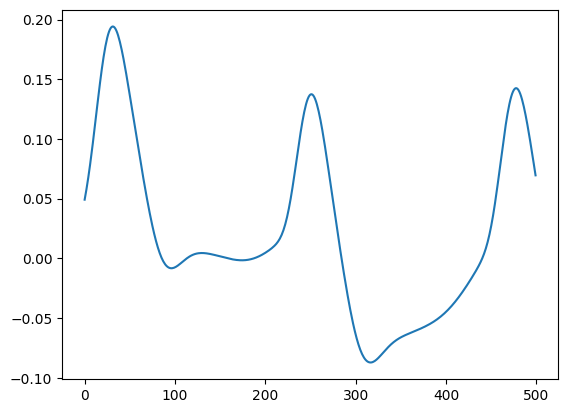

In [65]:
plt.plot(X_train[11])

X_train.shape


(39968, 500)

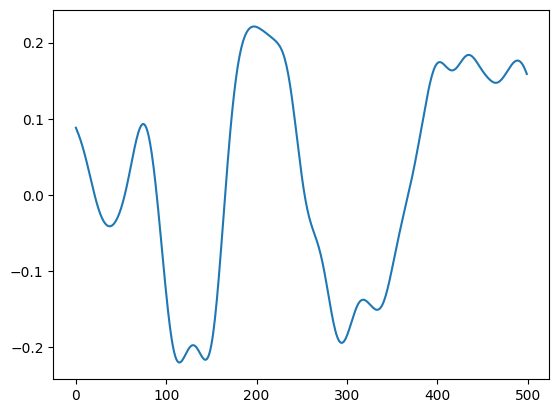

In [66]:
plt.plot(X_test[900])

X_test.shape


(26044, 500)

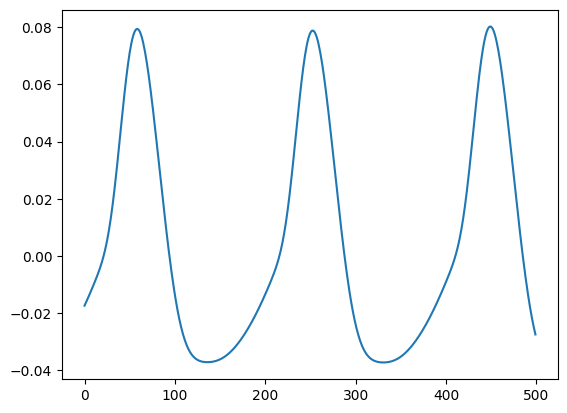

In [67]:
plt.plot(X_val[900])

X_val.shape


In [68]:
X_train = np.asarray(X_train_1)
X_val = np.asarray(X_val_1)


In [69]:
len(X_train), len(X_train > 3)

(142830, 142830)

In [70]:
len(X_train), len(X_train > 3)

(142830, 142830)

In [71]:
y_l = y_train.tolist()
len([i for i in y_l if i == [1,0,0]]), len([i for i in y_l if i == [0,1,0]]), len([i for i in y_l if i == [0,0,1]])

(132187, 5181, 5462)

In [72]:
import sklearn
X_train, y_train = sklearn.utils.shuffle(X_train, y_train)


'N'

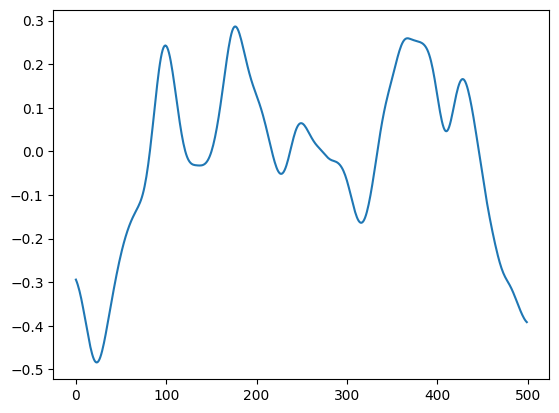

In [73]:
import matplotlib.pyplot as plt

beat = 10000
plt.plot(X_train[beat])
labels_train[beat]


In [74]:
y_l = y_train.tolist()
len([i for i in y_l if i == [1,0,0]]), len([i for i in y_l if i == [0,1,0]]), len([i for i in y_l if i == [0,0,1]])

(132187, 5181, 5462)

In [75]:
import sklearn
X_train, y_train = sklearn.utils.shuffle(X_train, y_train)


In [76]:
# Considering class imbalance: class weightning to reduce the bias in the dataset

from sklearn.utils.class_weight import compute_class_weight

y_integers = np.argmax(y_train, axis=1)

class_weights = compute_class_weight(
                                      class_weight = "balanced",
                                      classes = np.unique(y_integers),
                                      y = y_integers
                                    )

class_weights = dict(zip(np.unique(y_integers), class_weights))
class_weights


{0: 0.360171575117069, 1: 9.189345686160973, 2: 8.716587330648114}

In [77]:
X_train.shape, y_train.shape

((142830, 500), (142830, 3))

In [78]:
#class weights for validation set
from sklearn.utils.class_weight import compute_class_weight

y_integers = np.argmax(y_test, axis=1)

class_weights_test = compute_class_weight(
                                      class_weight = "balanced",
                                      classes = np.unique(y_integers),
                                      y = y_integers
                                    )

In [79]:
class_weights_test

array([ 0.36823291,  4.79232614, 13.21693122])

In [80]:
#class weights for validation set
from sklearn.utils.class_weight import compute_class_weight

y_integers = np.argmax(y_val, axis=1)

class_weights_val = compute_class_weight(
                                      class_weight = "balanced",
                                      classes = np.unique(y_integers),
                                      y = y_integers
                                    )

In [81]:
class_weights_val

array([0.37340674, 5.71140351, 6.80888889])

In [82]:
decode = dict(N =  0, S = 1, V  = 2)

In [83]:
X_train.shape

(142830, 500)

In [84]:
samples_class_weights_val = []
for y in y_val:
  samples_class_weights_val.append(class_weights_val[ohe.inverse_transform([y])[0][0]])

In [85]:
samples_class_weights_test = []
for y in y_test:
  samples_class_weights_test.append(class_weights_test[ohe.inverse_transform([y])[0][0]])

In [86]:
# Here we load validation data, training data can be loaded with the batch generator below

train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
testing_data = tf.data.Dataset.from_tensor_slices((X_test, y_test,samples_class_weights_test))
validation_data = tf.data.Dataset.from_tensor_slices((X_val, y_val, samples_class_weights_val))


In [87]:
len(train_data)


142830

In [88]:
len(testing_data)

39968

In [89]:
len(validation_data)

26044

In [90]:
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.metrics import confusion_matrix

#utility to plot confusion matrix and evaluation metrics
def evaluate_on_valid(model, batch_size, valid_to_use):
  #Computing the prediction of the model on the validation set
  predictions = []
  for element in valid_to_use.batch(batch_size).as_numpy_iterator():
      predictions.append(model.predict(element[0]))

  predictions_f = [item for sublist in predictions for item in sublist]

  predictions_oh = []
  #transform prediction into one-hot-encoding
  for i in range(len(predictions_f)):
      predictions_oh.append(tf.one_hot(tf.argmax(predictions_f[i]), depth=3))

  #Compute the true and prediction array in order to plot the confusion matrix
  y = []

  for y_t in y_val.tolist():
      if(y_t == [1, 0, 0]):
          y.append('N')
      if(y_t == [0, 1 ,0]):
          y.append('S')
      if(y_t == [0, 0 ,1]):
          y.append('V')

  y_pred = []

  for y_t in predictions_oh:
      if(all(tf.equal(y_t, tf.constant([1, 0, 0], dtype=np.float32)))):
          y_pred.append('N')
      elif(all(tf.equal(y_t, tf.constant([0, 1, 0], dtype=np.float32)))):
          y_pred.append('S')
      elif(all(tf.equal(y_t, tf.constant([0, 0, 1], dtype=np.float32)))):
          y_pred.append('V')
      else:
          print(y_t)

  # Plot confusion matrix and metrics
  ConfusionMatrixDisplay.from_predictions(y, y_pred, labels = ['N', 'S', 'V'])
  ConfusionMatrixDisplay.from_predictions(y, y_pred, normalize='true', labels = ['N', 'S', 'V'])

  print(classification_report(y,y_pred))

In [91]:
import tensorflow as tf

# Assuming win is defined somewhere earlier in your code
win = 250

# Define the seed for reproducibility
SEED = 42

vgg = tf.keras.Sequential()

vgg.add(tf.keras.layers.Conv1D(input_shape=(500, 1), filters=32, kernel_size=3, padding="same", activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(SEED)))
vgg.add(tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding="same", activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(SEED)))
vgg.add(tf.keras.layers.MaxPooling1D(pool_size=2, strides=2))
vgg.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding="same", activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(SEED)))
vgg.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding="same", activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(SEED)))
vgg.add(tf.keras.layers.MaxPooling1D(pool_size=2, strides=2))
vgg.add(tf.keras.layers.Conv1D(filters=128, kernel_size=3, padding="same", activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(SEED)))
vgg.add(tf.keras.layers.Conv1D(filters=128, kernel_size=3, padding="same", activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(SEED)))
vgg.add(tf.keras.layers.Conv1D(filters=128, kernel_size=3, padding="same", activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(SEED)))
vgg.add(tf.keras.layers.MaxPooling1D(pool_size=2, strides=2))
vgg.add(tf.keras.layers.Conv1D(filters=256, kernel_size=3, padding="same", activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(SEED)))
vgg.add(tf.keras.layers.Conv1D(filters=256, kernel_size=3, padding="same", activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(SEED)))
vgg.add(tf.keras.layers.Conv1D(filters=256, kernel_size=3, padding="same", activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(SEED)))
vgg.add(tf.keras.layers.MaxPooling1D(pool_size=2, strides=2))
vgg.add(tf.keras.layers.Conv1D(filters=256, kernel_size=3, padding="same", activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(SEED)))
vgg.add(tf.keras.layers.Conv1D(filters=256, kernel_size=3, padding="same", activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(SEED)))
vgg.add(tf.keras.layers.Conv1D(filters=256, kernel_size=3, padding="same", activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(SEED)))
vgg.add(tf.keras.layers.MaxPooling1D(pool_size=2, strides=2))
vgg.add(tf.keras.layers.Flatten())
vgg.add(tf.keras.layers.Dense(128, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(SEED)))
vgg.add(tf.keras.layers.Dropout(0.3, seed=SEED))
vgg.add(tf.keras.layers.Dense(3, activation='softmax'))

vgg.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
    loss='categorical_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(class_id=0),
             tf.keras.metrics.Recall(class_id=0),
             tf.keras.metrics.Precision(class_id=1),
             tf.keras.metrics.Recall(class_id=1),
             tf.keras.metrics.Precision(class_id=2),
             tf.keras.metrics.Recall(class_id=2)]
)

In [92]:
vgg.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 500, 32)           128       
                                                                 
 conv1d_1 (Conv1D)           (None, 500, 32)           3104      
                                                                 
 max_pooling1d (MaxPooling1  (None, 250, 32)           0         
 D)                                                              
                                                                 
 conv1d_2 (Conv1D)           (None, 250, 64)           6208      
                                                                 
 conv1d_3 (Conv1D)           (None, 250, 64)           12352     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 125, 64)           0         
 g1D)                                                   

In [93]:
train_data

<_TensorSliceDataset element_spec=(TensorSpec(shape=(500,), dtype=tf.float32, name=None), TensorSpec(shape=(3,), dtype=tf.float64, name=None))>

In [94]:
# Define the directory path
model_dir = '/content/applied'

# Ensure the directory exists
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    print(f"Directory created: {model_dir}")

# Define the test file path
test_file_path = os.path.join(model_dir, 'test_file.txt')
print(f"Test file will be saved at: {test_file_path}")

# Try saving a random thing (a simple text file) to the directory
try:
    with open(test_file_path, 'w') as f:
        f.write("This is a test file to check the directory path.\n")
    print(f"Test file saved successfully at: {test_file_path}")
except Exception as e:
    print(f"An error occurred while saving the test file: {e}")

# Verify that the test file was saved successfully
if os.path.exists(test_file_path):
    print("The test file was saved successfully.")
else:
    print("The test file was not saved. Check the path and permissions.")




Directory created: /content/applied
Test file will be saved at: /content/applied/test_file.txt
Test file saved successfully at: /content/applied/test_file.txt
The test file was saved successfully.


In [95]:
from google.colab import files

files.download(test_file_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [96]:
import os
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the Colab directory path
colab_model_dir = '/content/applied'

# Ensure the Colab directory exists
if not os.path.exists(colab_model_dir):
    os.makedirs(colab_model_dir)

# Define the full path to save the best model
colab_model_save_path = os.path.join(colab_model_dir, 'best_model_epoch_{epoch:02d}_val_loss_{val_loss:.2f}.h5')

# Define the ModelCheckpoint callback
colab_checkpoint_callback = ModelCheckpoint(
    filepath=colab_model_save_path,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=False,  # Ensure the full model is saved, not just weights
    verbose=1
)

# Compile the model
vgg.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(class_id=0),
        tf.keras.metrics.Recall(class_id=0),
        tf.keras.metrics.Precision(class_id=1),
        tf.keras.metrics.Recall(class_id=1),
        tf.keras.metrics.Precision(class_id=2),
        tf.keras.metrics.Recall(class_id=2)
    ]
)

# Train the model with the ModelCheckpoint callback
history = vgg.fit(
    train_data.batch(32),                    # Training data
    validation_data=validation_data.batch(32),  # Validation data
    shuffle=True,
    epochs=4,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True),
        colab_checkpoint_callback
    ]
).history

# Evaluate the model on the test data
results = vgg.evaluate(testing_data.batch(32))  # Test data

# Unpack results
(test_loss,
 test_accuracy,
 precision_class_0, recall_class_0,
 precision_class_1, recall_class_1,
 precision_class_2, recall_class_2) = results

# Print the results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Precision for class 0: {precision_class_0}")
print(f"Recall for class 0: {recall_class_0}")
print(f"Precision for class 1: {precision_class_1}")
print(f"Recall for class 1: {recall_class_1}")
print(f"Precision for class 2: {precision_class_2}")
print(f"Recall for class 2: {recall_class_2}")

print(f"Model saved to Colab path: {colab_model_save_path}")




Epoch 1/4
4464/4464 [==============================] - ETA: 0s - loss: 0.4622 - accuracy: 0.9241 - precision_3: 0.9259 - recall_3: 0.8542 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00


Epoch 1: val_loss improved from inf to 2.24496, saving model to /content/applied/best_model_epoch_01_val_loss_2.24.h5
4464/4464 [==============================] - 105s 17ms/step - loss: 0.4622 - accuracy: 0.9241 - precision_3: 0.9259 - recall_3: 0.8542 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - val_loss: 2.2450 - val_accuracy: 0.8927 - val_precision_3: 0.8927 - val_recall_3: 1.0000 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/4
4461/4464 [============================>.] - ETA: 0s - loss: 0.3202 - accuracy: 0.9255 - precision_3: 0.9255 - recall_3: 1.0000 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00


Epoch 2: val_loss improved from 2.24496 to 2.19453, saving model to /content/applied/best_model_epoch_02_val_loss_2.19.h5
4464/4464 [==============================] - 70s 16ms/step - loss: 0.3201 - accuracy: 0.9255 - precision_3: 0.9255 - recall_3: 1.0000 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - val_loss: 2.1945 - val_accuracy: 0.8927 - val_precision_3: 0.8927 - val_recall_3: 1.0000 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 3/4
4464/4464 [==============================] - ETA: 0s - loss: 0.3125 - accuracy: 0.9255 - precision_3: 0.9255 - recall_3: 1.0000 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00


Epoch 3: val_loss improved from 2.19453 to 2.13260, saving model to /content/applied/best_model_epoch_03_val_loss_2.13.h5
4464/4464 [==============================] - 57s 13ms/step - loss: 0.3125 - accuracy: 0.9255 - precision_3: 0.9255 - recall_3: 1.0000 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - val_loss: 2.1326 - val_accuracy: 0.8927 - val_precision_3: 0.8927 - val_recall_3: 1.0000 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 4/4
4464/4464 [==============================] - ETA: 0s - loss: 0.2994 - accuracy: 0.9255 - precision_3: 0.9255 - recall_3: 1.0000 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00


Epoch 4: val_loss improved from 2.13260 to 1.97153, saving model to /content/applied/best_model_epoch_04_val_loss_1.97.h5
4464/4464 [==============================] - 55s 12ms/step - loss: 0.2994 - accuracy: 0.9255 - precision_3: 0.9255 - recall_3: 1.0000 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - val_loss: 1.9715 - val_accuracy: 0.8927 - val_precision_3: 0.8927 - val_recall_3: 1.0000 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00


1249/1249 [==============================] - 8s 6ms/step - loss: 2.1030 - accuracy: 0.9052 - precision_3: 0.9052 - recall_3: 1.0000 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00
Test Loss: 2.102992057800293
Test Accuracy: 0.9052242040634155
Precision for class 0: 0.9052242040634155
Recall for class 0: 1.0
Precision for class 1: 0.0
Recall for class 1: 0.0
Precision for class 2: 0.0
Recall for class 2: 0.0
Model saved to Colab path: /content/applied/best_model_epoch_{epoch:02d}_val_loss_{val_loss:.2f}.h5


In [97]:
import os
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the Colab directory path
colab_model_dir = '/content/applied'

# Ensure the Colab directory exists
if not os.path.exists(colab_model_dir):
    os.makedirs(colab_model_dir)

# Define the full path to save the best model
colab_model_save_path = os.path.join(colab_model_dir, 'best_model_epoch_{epoch:02d}_val_loss_{val_loss:.2f}.h5')

# Define the ModelCheckpoint callback
colab_checkpoint_callback = ModelCheckpoint(
    filepath=colab_model_save_path,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=False,  # Ensure the full model is saved, not just weights
    verbose=1
)

# Custom metric functions
def true_positives(y_true, y_pred):
    return tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 1), tf.equal(tf.round(y_pred), 1)), tf.float32))

def false_positives(y_true, y_pred):
    return tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 0), tf.equal(tf.round(y_pred), 1)), tf.float32))

def true_negatives(y_true, y_pred):
    return tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 0), tf.equal(tf.round(y_pred), 0)), tf.float32))

def false_negatives(y_true, y_pred):
    return tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 1), tf.equal(tf.round(y_pred), 0)), tf.float32))

def custom_metric(y_true, y_pred):
    TP = true_positives(y_true, y_pred)
    FP = false_positives(y_true, y_pred)
    TN = true_negatives(y_true, y_pred)
    FN = false_negatives(y_true, y_pred)

    # Adjusting metrics based on empirical penalties and thresholds
    penalty_factor = 0.1
    adjusted_metric = TP - penalty_factor * (FP + FN)

    return adjusted_metric

# Compile the model
vgg.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        custom_metric,
        tf.keras.metrics.Precision(class_id=0),
        tf.keras.metrics.Recall(class_id=0),
        tf.keras.metrics.Precision(class_id=1),
        tf.keras.metrics.Recall(class_id=1),
        tf.keras.metrics.Precision(class_id=2),
        tf.keras.metrics.Recall(class_id=2)
    ]
)

# Train the model with the ModelCheckpoint callback
history = vgg.fit(
    train_data.batch(32),                    # Training data
    validation_data=validation_data.batch(32),  # Validation data
    shuffle=True,
    epochs=4,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True),
        colab_checkpoint_callback
    ]
).history

# Evaluate the model on the test data
results = vgg.evaluate(testing_data.batch(32))  # Test data

# Unpack results
(test_loss,
 test_accuracy,
 custom_metric_result,
 precision_class_0, recall_class_0,
 precision_class_1, recall_class_1,
 precision_class_2, recall_class_2) = results

# Print the results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Custom Metric Result: {custom_metric_result}")
print(f"Precision for class 0: {precision_class_0}")
print(f"Recall for class 0: {recall_class_0}")
print(f"Precision for class 1: {precision_class_1}")
print(f"Recall for class 1: {recall_class_1}")
print(f"Precision for class 2: {precision_class_2}")
print(f"Recall for class 2: {recall_class_2}")

print(f"Model saved to Colab path: {colab_model_save_path}")


Epoch 1/4
4460/4464 [============================>.] - ETA: 0s - loss: 0.2782 - accuracy: 0.9254 - custom_metric: 29.1157 - precision_6: 0.9256 - recall_6: 0.9993 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - precision_8: 0.0000e+00 - recall_8: 0.0000e+00


Epoch 1: val_loss improved from inf to 1.80496, saving model to /content/applied/best_model_epoch_01_val_loss_1.80.h5
4464/4464 [==============================] - 67s 14ms/step - loss: 0.2782 - accuracy: 0.9255 - custom_metric: 29.1131 - precision_6: 0.9257 - recall_6: 0.9993 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - precision_8: 0.0000e+00 - recall_8: 0.0000e+00 - val_loss: 1.8050 - val_accuracy: 0.8927 - val_custom_metric: 27.8382 - val_precision_6: 0.8929 - val_recall_6: 0.9988 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00 - val_precision_8: 0.0000e+00 - val_recall_8: 0.0000e+00
Epoch 2/4
4463/4464 [============================>.] - ETA: 0s - loss: 0.2632 - accuracy: 0.9253 - custom_metric: 29.0546 - precision_6: 0.9285 - recall_6: 0.9971 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - precision_8: 0.0000e+00 - recall_8: 0.0000e+00


Epoch 2: val_loss improved from 1.80496 to 1.72851, saving model to /content/applied/best_model_epoch_02_val_loss_1.73.h5
4464/4464 [==============================] - 58s 13ms/step - loss: 0.2632 - accuracy: 0.9254 - custom_metric: 29.0512 - precision_6: 0.9285 - recall_6: 0.9971 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - precision_8: 0.0000e+00 - recall_8: 0.0000e+00 - val_loss: 1.7285 - val_accuracy: 0.8926 - val_custom_metric: 27.8112 - val_precision_6: 0.9016 - val_recall_6: 0.9969 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00 - val_precision_8: 0.0000e+00 - val_recall_8: 0.0000e+00
Epoch 3/4
4463/4464 [============================>.] - ETA: 0s - loss: 0.2546 - accuracy: 0.9256 - custom_metric: 29.0147 - precision_6: 0.9342 - recall_6: 0.9953 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - precision_8: 0.0000e+00 - recall_8: 0.0000e+00


Epoch 3: val_loss improved from 1.72851 to 1.69964, saving model to /content/applied/best_model_epoch_03_val_loss_1.70.h5
4464/4464 [==============================] - 59s 13ms/step - loss: 0.2546 - accuracy: 0.9256 - custom_metric: 29.0113 - precision_6: 0.9342 - recall_6: 0.9953 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - precision_8: 0.0000e+00 - recall_8: 0.0000e+00 - val_loss: 1.6996 - val_accuracy: 0.8941 - val_custom_metric: 27.7856 - val_precision_6: 0.9104 - val_recall_6: 0.9951 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00 - val_precision_8: 0.0000e+00 - val_recall_8: 0.0000e+00
Epoch 4/4
4462/4464 [============================>.] - ETA: 0s - loss: 0.2501 - accuracy: 0.9265 - custom_metric: 28.9642 - precision_6: 0.9380 - recall_6: 0.9933 - precision_7: 0.3333 - recall_7: 5.7904e-04 - precision_8: 0.0000e+00 - recall_8: 0.0000e+00


Epoch 4: val_loss improved from 1.69964 to 1.67600, saving model to /content/applied/best_model_epoch_04_val_loss_1.68.h5
4464/4464 [==============================] - 57s 13ms/step - loss: 0.2500 - accuracy: 0.9266 - custom_metric: 28.9613 - precision_6: 0.9380 - recall_6: 0.9933 - precision_7: 0.3333 - recall_7: 5.7904e-04 - precision_8: 0.0000e+00 - recall_8: 0.0000e+00 - val_loss: 1.6760 - val_accuracy: 0.8958 - val_custom_metric: 27.7548 - val_precision_6: 0.9139 - val_recall_6: 0.9938 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00 - val_precision_8: 0.0000e+00 - val_recall_8: 0.0000e+00


1249/1249 [==============================] - 7s 5ms/step - loss: 1.9265 - accuracy: 0.9051 - custom_metric: 28.1458 - precision_6: 0.9152 - recall_6: 0.9921 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - precision_8: 0.0000e+00 - recall_8: 0.0000e+00
Test Loss: 1.9264599084854126
Test Accuracy: 0.9050740599632263
Custom Metric Result: 28.145803451538086
Precision for class 0: 0.9152196645736694
Recall for class 0: 0.9920950531959534
Precision for class 1: 0.0
Recall for class 1: 0.0
Precision for class 2: 0.0
Recall for class 2: 0.0
Model saved to Colab path: /content/applied/best_model_epoch_{epoch:02d}_val_loss_{val_loss:.2f}.h5


814/814 [==============================] - 4s 4ms/step


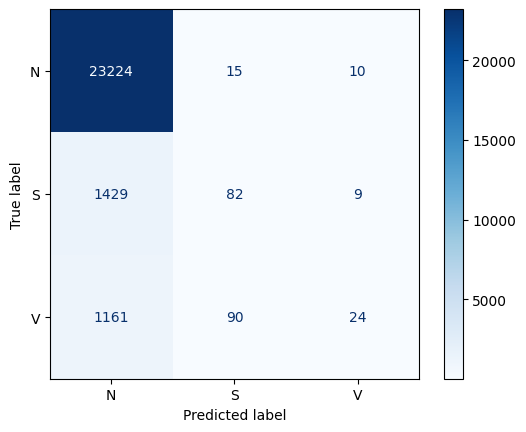

In [98]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming validation_data and vgg model are defined and the model is trained

# Generate predictions for the validation dataset
predictions_oh_val = vgg.predict(validation_data.batch(32))

# Assuming y_val is the true labels from the validation dataset
# If y_val is not already defined, you need to extract it from validation_data
# For this example, let's assume y_val is already a TensorFlow tensor or a NumPy array

# Convert TensorFlow tensors to NumPy arrays if necessary
if isinstance(y_val, tf.Tensor):
    y_val_numpy = y_val.numpy()
else:
    y_val_numpy = y_val

# Convert predictions to NumPy array if necessary
if isinstance(predictions_oh_val, tf.Tensor):
    predictions_oh_val_numpy = predictions_oh_val.numpy()
else:
    predictions_oh_val_numpy = predictions_oh_val

# Extract true labels from the validation dataset
y_val_true = [np.argmax(y) for y in y_val_numpy]

# Extract predicted labels from the one-hot encoded predictions
y_val_pred = [np.argmax(y) for y in predictions_oh_val_numpy]

# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

# Call the function to plot confusion matrix
plot_confusion_matrix(y_val_true, y_val_pred, classes=['N', 'S', 'V'])


In [99]:
vgg.save('/gdrive/My Drive/VGG_Multiclass.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [103]:
import os
import re
import numpy as np
import scipy.io as sio
from scipy import signal
import tensorflow as tf

# Utility functions
def ppg_freq(filename):
    if '128' in filename:
        return 128
    else:
        return 250

def load_data(file):
    original = sio.loadmat(file)
    spk_file = file.replace('.mat', '_spk.mat')
    spk = sio.loadmat(spk_file)
    return original, spk

def filter_files_by_pattern(directory, pattern):
    files = os.listdir(directory)
    filtered_files = [file for file in files if re.match(pattern, file)]
    return filtered_files

def normalize(data):
    return (data - np.mean(data)) / np.std(data)

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

def from_freq_to_freq(sample, ini_freq, freq=250):
    secs = sample / ini_freq  # Number of seconds in signal
    samp = secs * freq        # Number of samples to downsample
    return int(samp)

# Custom metric (replace with your actual custom metric if you have one)
def custom_metric(y_true, y_pred):
    return tf.reduce_mean(y_true - y_pred)

# Path to the test data
path_to_test_data = '/gdrive/My Drive/test_students_1'
path_to_test_output = '/gdrive/My Drive/test_output_Multiclass'
pattern = r'S\d{3}_\d{3}\.mat'
filtered_test_files = filter_files_by_pattern(path_to_test_data, pattern)

# Load the trained model
with tf.keras.utils.custom_object_scope({'custom_metric': custom_metric}):
    model = tf.keras.models.load_model('/gdrive/My Drive/VGG_Multiclass.h5')

# Preprocess the test data
win = 250
lowcut = 0.5
highcut = 8.0
fs = 250

for file in filtered_test_files:
    ppg, spk = load_data(path_to_test_data + '/' + file)
    original_fs = ppg_freq(file)
    resampled = signal.resample_poly(ppg['ppg'][:, 0], 250, original_fs) if original_fs != 250 else ppg['ppg'][:, 0]
    normalized = normalize(resampled)
    filtered = butter_bandpass_filter(normalized, lowcut, highcut, fs)

    heartbeats = []
    for j in range(len(spk['speaks'])):
        speak_sample = from_freq_to_freq(spk['speaks'][j], original_fs)
        if speak_sample >= win and speak_sample + win <= from_freq_to_freq(spk['speaks'][-1], original_fs):
            heartbeats.append(filtered[speak_sample - win : speak_sample + win])

    heartbeats = np.array(heartbeats)
    X_test = tf.keras.preprocessing.sequence.pad_sequences(heartbeats, maxlen=win * 2, dtype='float32', truncating='post', padding="post")

    # Predict the labels for the heartbeats
    predictions = model.predict(X_test)
    predicted_labels = np.argmax(predictions, axis=1)

    # Convert numeric predictions to labels
    label_map = {0: 'N', 1: 'S', 2: 'V'}
    predicted_labels = [label_map[label] for label in predicted_labels]

    # Save the predicted labels in the corresponding _ann file
    ann_file = file.replace('.mat', '_ann.mat')
    sio.savemat(path_to_test_output + '/' + ann_file, {'labels': predicted_labels})

    print(f"Processed file {file} and saved predictions to {ann_file}")


<ipython-input-103-739d6c6bac5d>:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(samp)


58/58 [==============================] - 1s 9ms/step
Processed file S063_128.mat and saved predictions to S063_128_ann.mat
45/45 [==============================] - 0s 8ms/step
Processed file S066_128.mat and saved predictions to S066_128_ann.mat
95/95 [==============================] - 1s 6ms/step
Processed file S077_128.mat and saved predictions to S077_128_ann.mat
71/71 [==============================] - 1s 15ms/step
Processed file S070_128.mat and saved predictions to S070_128_ann.mat
73/73 [==============================] - 1s 10ms/step
Processed file S074_128.mat and saved predictions to S074_128_ann.mat
80/80 [==============================] - 1s 7ms/step
Processed file S076_128.mat and saved predictions to S076_128_ann.mat
60/60 [==============================] - 1s 8ms/step
Processed file S078_128.mat and saved predictions to S078_128_ann.mat
105/105 [==============================] - 0s 3ms/step
Processed file S069_128.mat and saved predictions to S069_128_ann.mat
64/64 [=====